# Create ALM 5MW case

In [1]:
# Add any possible locations of amr-wind-frontend here
amrwindfedirs = ['/projects/wind_uq/lcheung/amrwind-frontend',
                 '/ccs/proj/cfd162/lcheung/amrwind-frontend/']
import sys, os, shutil
for x in amrwindfedirs: sys.path.insert(1, x)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math
import pandas as pd
import postproamrwindsample as ppsample
import time
import utm
import shutil
import yaml

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/ascldap/users/lcheung/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (


In [2]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

**Note**: in order to run this notebook correctly, you need access to the precursor run directory, and the setup/postprocessing files in there.

In [3]:
# Location of precursor run with boundary data
precursordir  = '/gpfs/lcheung/HFM/exawind-benchmarks/convective_abl'
precursorsetup= precursordir+'/neutral_abl_bndry.inp'

# Location of farm run dir
farmrundir       = '../input_files'              # Put all 
outputfile       = 'NREL5MW_ALM_BD.inp'
noturboutputfile = 'NREL5MW_ALM_BD_noturb.inp'
BRoutputfile     = 'NREL5MW_BR.inp'

verbose          = True
cwd              = os.getcwd()

# Go to the run directory
if os.path.exists(farmrundir):
    shutil.rmtree(farmrundir)

os.makedirs(farmrundir, exist_ok = True)
os.chdir(farmrundir)

# Load the starting point
case.loadAMRWindInput(precursorsetup)

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()


OrderedDict([('io.line_plot_int', '1'),
             ('CoriolisForcing.turn_off_vertical_force', 'True')])

In [4]:
tstart = 15000
tstop  = tstart+1000

In [5]:
OFdt = 0.0008608815426997245      # Time step for OpenFAST beamdyn

# Set the time constants
case.setAMRWindInput('time.stop_time', tstop)
case.setAMRWindInput('time.fixed_dt', OFdt*20)
case.setAMRWindInput('time.max_step',  -1)

In [6]:
# set verbosity
case.setAMRWindInput('incflo.verbose', 0)

In [7]:
# Set the restart point
chkdir = precursordir+'/chk30000/'
case.setAMRWindInput('restart_file', os.path.realpath(chkdir))

In [8]:
# Set the boundary input file parameters
ablstatfile = precursordir+'/post_processing/abl_statistics30000.nc'
#tavg        =  [tstart, tstop]
tavg        = [15000, 16000]
forcingdict = {'ablstatfile':ablstatfile, 'tavg':tavg}
inflowplanes= ['xlo', 'ylo'] 
bndryfiles  = precursordir+'/bndry_file'

In [9]:
case.boundaryplane_restart(bndryfiles=bndryfiles, 
                           forcingdict=forcingdict, 
                           inflowplanes=inflowplanes, 
                           checkpointdir=chkdir,
                           autoset_wf_properties=True,
                           ABLMeanBoussinesqTemperatureFile='avg_theta.dat',
                           verbose=True)

SET ABL_bndry_io_mode = '1'
SET ABL_bndry_file = '/gpfs/lcheung/HFM/exawind-benchmarks/convective_abl/bndry_file'
SET ABL_bndry_planes = ['xlo', 'ylo']
SET is_periodicx = False
SET is_periodicy = False
SET xlo_type = 'mass_inflow'
SET xlo_density = 1.0
SET xlo_temperature = 0.0
SET xlo_tke = 0.0
SET ylo_type = 'mass_inflow'
SET ylo_density = 1.0
SET ylo_temperature = 0.0
SET ylo_tke = 0.0
SET xhi_type = 'pressure_outflow'
SET xhi_density = None
SET xhi_temperature = None
SET xhi_tke = None
SET yhi_type = 'pressure_outflow'
SET yhi_density = None
SET yhi_temperature = None
SET yhi_tke = None
SET BodyForce = True
SET BodyForce_magnitude = [-0.0002743665569299508, 0.0011708563286373845, 0.0]
SET ABLForcing = False
SET ABLMeanBoussinesq = True
Loading theta
SET read_temperature_profile = True
SET temperature_profile_filename = 'avg_theta.dat'
Loading u
Loading v
Loading theta
Loading hvelmag
SET wf_velocity = [6.0977889026612075, 3.6097639593035185]
SET wf_vmag = 7.103916682319445
SET wf_t

## Add the turbine

In [10]:
turbbase_xy = [[1800, 1800]]

In [11]:
# Build the CSV input file of turbine layouts for amrwind-frontend
OFoptions=(
           # "FSTparam_CompServo:0 "
           "FSTparam_DT:0.0008608815426997245 "
           "EDparam_YawDOF:False "
           "AMRparam_Actuator_epsilon:[4.41;4.41;4.41] "
           "AMRparam_Actuator_epsilon_tower:[4.41;4.41;4.41] "
           "AMRparam_Actuator_openfast_stop_time:3000.0 "
          )
#"ADparam_TwrAero:False ADparam_TwrShadow:0 ADparam_TwrPotent:0 "

turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
"""
rowformat="T%i, %f, %f, NREL5MW_v355_ALM_BD, 240.0, ,%s\n"
for iturb, xy in enumerate(turbbase_xy):
    turboptions  = OFoptions
    turbinescsv += rowformat%(iturb, xy[0], xy[1], turboptions)
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)
print(turbinescsv)


# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
T0, 1800.000000, 1800.000000, NREL5MW_v355_ALM_BD, 240.0, ,FSTparam_DT:0.0008608815426997245 EDparam_YawDOF:False AMRparam_Actuator_epsilon:[4.41;4.41;4.41] AMRparam_Actuator_epsilon_tower:[4.41;4.41;4.41] AMRparam_Actuator_openfast_stop_time:3000.0 



In [12]:
case.setAMRWindInput('turbines_createnewdomain', False)
case.setAMRWindInput('turbines_deleteprev', True)

case.turbines_createAllTurbines()

docopy = True from /projects/wind_uq/lcheung/amrwind-frontend/turbines/NREL5MW_v355 to T0_NREL5MW_v355
T0_NREL5MW_v355/openfast-cpp/5MW_Land_DLL_WTurb_cpp/5MW_Land_DLL_WTurb_cpp.fst
Fixing yaw in /projects/wind_uq/lcheung/exawind-benchmarks.lcheung/amr-wind/actuator_line/NREL5MW_ALM_BD/input_files/T0_NREL5MW_v355/openfast-cpp/5MW_Land_DLL_WTurb_cpp/NRELOffshrBsline5MW_Onshore_ElastoDyn.dat
MISMATCH between incflo.density = 1.000000 and OpenFAST density = 1.225000
USING incflo value
Setting Actuator_epsilon to [4.41, 4.41, 4.41]
Setting Actuator_epsilon_tower to [4.41, 4.41, 4.41]
Setting Actuator_openfast_stop_time to 3000.0
OrderedDict([('DT', 0.0008608815426997245)])
OrderedDict([('YawDOF', 'False')])


      30.0 NacYaw - Initial or fixed nacelle-yaw angle (degrees) [EDITED]
       1.0 AirDens - Air density (kg/m^3) [EDITED]
0.0008608815426997245 DT - Recommended module time step (s) [EDITED] [EDITED]
     False YawDOF - Yaw DOF (flag) [EDITED]


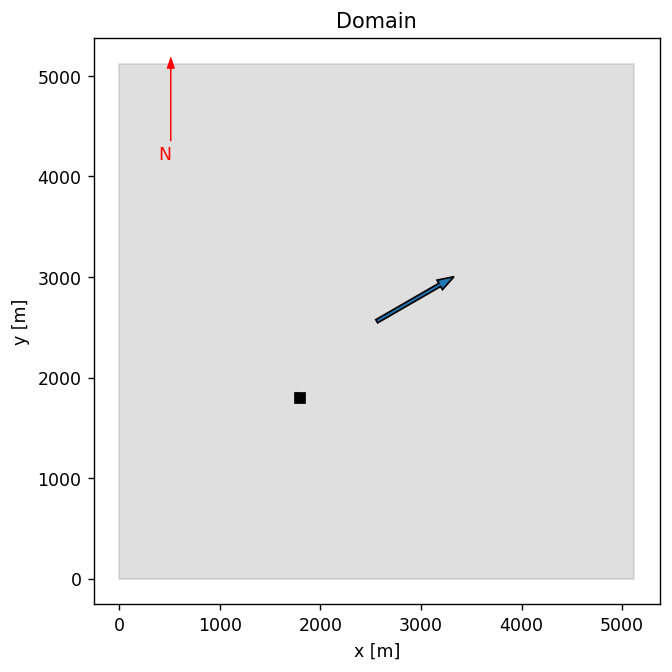

In [13]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = [] #['p_hub']
case.plotDomain(ax=ax)
for iturb, xy in enumerate(turbbase_xy):
    ax.plot(xy[0], xy[1], 'ks')

## Add refinement regions

In [14]:
## Add refinement zones
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     5,        10,         5,     0.75,   2,
1,     2.5,      5,          2,     0.75,   1.5,
2,     1.25,     2.0,        1.25,  0.75,   1.0, 
3,     0.75,     0.75,       1.00,  0.75,   0.75, 
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

# Uncomment this to create refinement zones
case.refine_createAllZones()

In [15]:
case.estimateMeshSize()

Refinement T0_level_0_zone: level 1: 6601240 cells
Refinement T0_level_1_zone: level 2: 8641624 cells
Refinement T0_level_2_zone: level 3: 14562737 cells
Refinement T0_level_3_zone: level 4: 36870930 cells
ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0     50331648             10.0 x 10.0 x 10.0
       1      6601240                5.0 x 5.0 x 5.0
       2      8641624                2.5 x 2.5 x 2.5
       3     14562737             1.25 x 1.25 x 1.25
       4     36870930          0.625 x 0.625 x 0.625
  TOTAL:    117008179


## Add sampling planes

In [16]:
# First delete everything that already exists
case.listboxpopupwindict['listboxsampling'].deleteall()
case.listboxpopupwindict['listboxpostprosetup'].deleteall()

In [17]:
## virtual metmast measurements
metmastpprosetup = case.get_default_postprosetupdict()
metmastpprosetup['postprocessing_setup_name'] = 'metmast_'
metmastpprosetup['postprocessing_setup_type'] = 'Sampling'
metmastpprosetup['postprocessing_setup_output_frequency'] =  1
metmastpprosetup['postprocessing_setup_fields']           =  ['velocity', 'temperature', 'tke']
case.add_postprosetup(metmastpprosetup, verbose=True)

sampledict = case.get_default_samplingdict()
sampledict['sampling_name']     = 'virtualmast'
sampledict['sampling_outputto'] = 'metmast_'
sampledict['sampling_type']     = 'LineSampler'
sampledict['sampling_l_num_points'] = 20
sampledict['sampling_l_start']      = [1800, 1800, 10.0]
sampledict['sampling_l_end']        = [1800, 1800, 200.0]
case.add_sampling(sampledict, verbose=False)

postprocessing_setup_name: 'metmast_'
postprocessing_setup_type: 'Sampling'
postprocessing_setup_output_frequency: 1
postprocessing_setup_fields: ['velocity', 'temperature', 'tke']
postprocessing_setup_derived_fields: None
postprocessing_setup_averaging_window: None
postprocessing_setup_averaging_start_time: None
postprocessing_setup_averaging_stop_time: None


In [18]:
outputoptions="outputvars:velocity;tke;temperature outputfreq:100"
samplingcsv="""
# CSV file should have columns withturbinescsv
# name, type, upstream, downstream, lateral, below, above, n1, n2, options
name,      type, upstream, downstream, lateral, below, above, n1, n2,  options
rotorplaneUP,  rotorplane, 4,     0,       2,    0.7,      1,  11, 11,           usedx:0.05 outputto:rotorplaneUP_  orientation:nacdir {outputoptions} noffsets:4
rotorplaneDN,  rotorplane, 0,     10,      2,    0.7,      1,  11, 11,           usedx:0.05 outputto:rotorplaneDN_  orientation:nacdir {outputoptions} noffsets:10
nearwake,    rotorplane, 0,       2,      2,    0.7,      1,  11, 11,            usedx:0.05 outputto:nearwake_      orientation:nacdir {outputoptions} noffsets:4
turbsw,      streamwise, 4,       10,      0,    0.7,     1.5, 11, 11,           usedx:0.05 outputto:turbsw_        orientation:nacdir {outputoptions} noffsets:0
turbhh,      hubheight,  4,       10,      2,       0,    0,   11, 11,           usedx:0.05 outputto:turbhh_        orientation:nacdir {outputoptions} noffsets:0
XYdomain027, hubheight,  8,       8,       2,       0,    90,  11, 11, units:meter usedx:10 outputto:XYdomain_027_ orientation:nacdir center:specified centerx:100 centery:100 centerz:27 wholedomain:1  {outputoptions} noffsets:0
XYdomain090, hubheight,  8,       8,       2,       0,    90,  11, 11, units:meter usedx:10 outputto:XYdomain_090_ orientation:nacdir center:specified centerx:100 centery:100 centerz:90 wholedomain:1  {outputoptions} noffsets:0
XYdomain153, hubheight,  8,       8,       2,       0,    153, 11, 11, units:meter usedx:10 outputto:XYdomain_153_ orientation:nacdir center:specified centerx:100 centery:100 centerz:153 wholedomain:1  {outputoptions} noffsets:0
""".format(outputoptions=outputoptions)

case.setAMRWindInput('sampling_csvtextbox', samplingcsv)
case.setAMRWindInput('sampling_deleteprev', False)

In [19]:
case.sampling_createAllProbes(verbose=False)
# Print out existing list of turbines
print(case.listboxpopupwindict['listboxsampling'].getitemlist())

['virtualmast', 'T0_rotorplaneUP', 'T0_rotorplaneDN', 'T0_nearwake', 'T0_turbsw', 'T0_turbhh', 'Farm_XYdomain027', 'Farm_XYdomain090', 'Farm_XYdomain153']


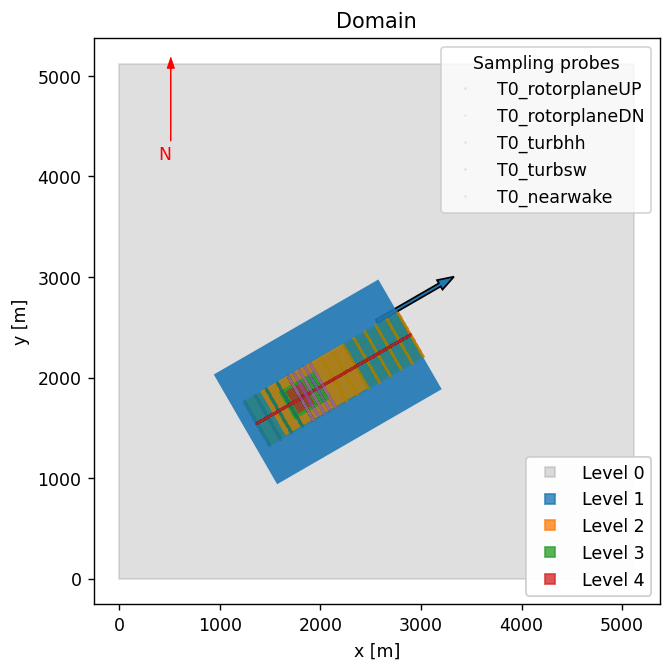

In [20]:
fig, ax = plt.subplots(figsize=(6,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = ['T0_rotorplaneUP', 'T0_rotorplaneDN', 'T0_turbhh', 'T0_turbsw','T0_nearwake'] #case.listboxpopupwindict['listboxsampling'].getitemlist() #['p_hub']
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':.25, 'marker':'.', 'linestyle':'None', 'alpha':0.1}"
case.popup_storteddata['plotdomain']['plot_chooseview']      = 'XY'
case.plotDomain(ax=ax)

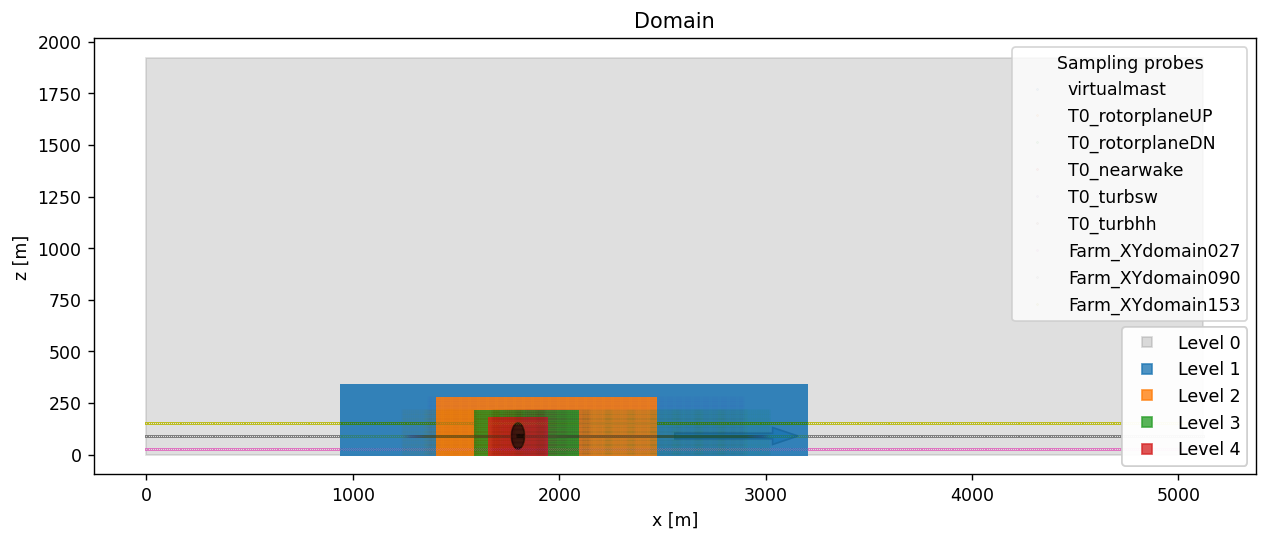

In [21]:
fig, ax = plt.subplots(figsize=(12,6), facecolor='w', dpi=125)

# Set any additional items to plot
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_sampleprobes']    = case.listboxpopupwindict['listboxsampling'].getitemlist() #['p_hub']
case.popup_storteddata['plotdomain']['plot_sampleprobes_style'] = "{'markersize':.1, 'marker':'.', 'linestyle':'None', 'alpha':0.1}"
case.popup_storteddata['plotdomain']['plot_chooseview'] = 'XZ'
case.plotDomain(ax=ax)

In [22]:
case.validate();

-- Checking inputs --
[ PASS] max_level:           max_level = 4 >= 0
[ PASS] dt & CFL:            DT and CFL OK
[ PASS] restart dir:         Restart directory /gpfs/lcheung/HFM/exawind-benchmarks/Neutral_ABL/chk30000 exists
[ PASS] boundary plane dir:  Restart directory /gpfs/lcheung/HFM/exawind-benchmarks/convective_abl/bndry_file exists
[ PASS] Actuator physics:    incflo.physics and ICNS.source_terms OK for Actuators
[ PASS] Actuator FST:T0      [T0_NREL5MW_v355/openfast-cpp/5MW_Land_DLL_WTurb_cpp/5MW_Land_DLL_WTurb_cpp.fst] exists
[ PASS] Actuator FST:T0      Actuator density=1.000000, matches incflo.density=1.000000
[ PASS] Actuator FST:T0      CompInflow OK
[ PASS] Actuator FST:T0      [T0_NREL5MW_v355/openfast-cpp/5MW_Land_DLL_WTurb_cpp/NRELOffshrBsline5MW_Onshore_AeroDyn15.dat] exists
[ PASS] Actuator FST:T0      WakeMod=0 OK
[ PASS] Actuator FST:T0      AirDens=1.000000, matches incflo.density=1.000000
[ PASS] Sampling probes:virtualmast is inside domain
[ PASS] Sampling prob

## Write out the input file

### For the w/turbine ALM case

In [23]:
# For the w/turbine ALM case
case.setAMRWindInput('amr.max_level',  2)
print(case.writeAMRWindInput(outputfile))

# --- Simulation time control parameters ---
time.stop_time                           = 16000.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.01721763085399449 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 10000               
time.checkpoint_start                    = 30000               
incflo.physics                           = ABL Actuator        # List of physics models to include in simulation.
incflo.verbose                           = 0                   
io.check_file                            = chk                 
io.restart_file                          = /gpfs/lcheung/HFM/exawind-benchmarks/Neutral_ABL/chk30000
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84   

### For the without turbine ALM case

In [24]:
# For the w/o turbine ALM case
case.removeturbines()
print(case.writeAMRWindInput(noturboutputfile))

# --- Simulation time control parameters ---
time.stop_time                           = 16000.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.01721763085399449 # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 10000               
time.checkpoint_start                    = 30000               
incflo.physics                           = ABL                 # List of physics models to include in simulation.
incflo.verbose                           = 0                   
io.check_file                            = chk                 
io.restart_file                          = /gpfs/lcheung/HFM/exawind-benchmarks/Neutral_ABL/chk30000
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84   

### For the blade resolved case

In [25]:
# For the blade resolved case
case.setAMRWindInput('amr.max_level',  4)
case.setAMRWindInput('time.fixed_dt',  0.003443526170799) # = OFdt*4

# These are extra parameters needed for the hybrid solver
extraparams = """
ABL.enable_hybrid_rl_mode                = true                
amr.max_grid_size                        = 128                 
amr.blocking_factor                      = 32                  
nodal_proj.max_coarsening_level          = 0                   
nodal_proj.num_pre_smooth                = 10                  
nodal_proj.num_post_smooth               = 10                  
nodal_proj.bottom_rtol                   = 1.0e-9              
nodal_proj.bottom_atol                   = 1.0e-12             
mac_proj.verbose                         = 0                   
mac_proj.max_coarsening_level            = 0                   
mac_proj.do_nsolve                       = true                
mac_proj.bottom_verbose                  = 0                   
mac_proj.bottom_rtol                     = 1.0e-11             
mac_proj.bottom_atol                     = 1.0e-12             
mac_proj.num_pre_smooth                  = 10                  
mac_proj.num_post_smooth                 = 10                  
diffusion.verbose                        = 0                   
diffusion.do_agglomeration               = false               
diffusion.do_nsolve                      = true                
velocity_diffusion.verbose               = 0                   
velocity_diffusion.use_tensor_operator   = false               
velocity_diffusion.use_segregated_operator = true                
velocity_diffusion.do_nsolve             = true                
temperature_diffusion.verbose            = 0                   
temperature_diffusion.do_nsolve          = true                
amrex.abort_on_out_of_gpu_memory         = 1                   
amrex.the_arena_is_managed               = 0                   
amrex.hypre_spgemm_use_vendor            = 1                   
amrex.hypre_spmv_use_vendor              = 0                   
amrex.hypre_sptrans_use_vendor           = 0                   
amrex.hypre_umpire_device_pool_mbs       = 4096                
hypre.bamg_verbose                       = 0                   
hypre.verbose                            = 0                   
hypre.recompute_preconditioner           = 0                   
hypre.hypre_solver                       = GMRES               
hypre.hypre_preconditioner               = BoomerAMG           
hypre.num_krylov                         = 40                  
hypre.max_iterations                     = 40                  
hypre.rtol                               = 1.e-5               
hypre.atol                               = 1.e-8               
hypre.bamg_coarsen_type                  = 8                   
hypre.bamg_interp_type                   = 6                   
hypre.bamg_relax_type                    = 11                  
hypre.bamg_num_sweeps                    = 2                   
hypre.bamg_cycle_type                    = 1                   
hypre.bamg_relax_order                   = 0                   
hypre.bamg_trunc_factor                  = 0.45                
hypre.bamg_strong_threshold              = 0.3                 
hypre.bamg_min_coarse_size               = 1                   
hypre.bamg_max_coarse_size               = 100                 
hypre.bamg_agg_num_levels                = 0                   
hypre.bamg_agg_interp_type               = 7                   
hypre.bamg_agg_pmax_elmts                = 3                   
hypre.bamg_pmax_elmts                    = 3                   
hypre.bamg_keep_transpose                = 1                   
hypre.write_matrix_files                 = 0                   
hypre.bamg_smooth_type                   = 5                   
hypre.bamg_smooth_num_sweeps             = 1                   
hypre.bamg_smooth_num_levels             = 0                   
hypre.bamg_ilu_type                      = 0                   
hypre.bamg_ilu_level                     = 0                   
hypre.bamg_ilu_max_iter                  = 1                   
hypre.bamg_ilu_reordering_type           = 0                   
hypre.bamg_ilu_tri_solve                 = 0                   
hypre.bamg_ilu_lower_jacobi_iters        = 3                   
hypre.bamg_ilu_upper_jacobi_iters        = 3                   
"""
case.loadAMRWindInput(extraparams, string=True);
print(case.writeAMRWindInput(BRoutputfile))

# --- Simulation time control parameters ---
time.stop_time                           = 16000.0             # Max (simulated) time to evolve [s]
time.max_step                            = -1                  
time.fixed_dt                            = 0.003443526170799   # Fixed timestep size (in seconds). If negative, then time.cfl is used
time.checkpoint_interval                 = 10000               
time.checkpoint_start                    = 30000               
incflo.physics                           = ABL                 # List of physics models to include in simulation.
incflo.verbose                           = 0                   
io.check_file                            = chk                 
io.restart_file                          = /gpfs/lcheung/HFM/exawind-benchmarks/Neutral_ABL/chk30000
incflo.use_godunov                       = true                
incflo.godunov_type                      = weno_z              
turbulence.model                         = OneEqKsgsM84   